# Estimating Correlations between Clinical Trials Outcomes (Three Phases)

Sergey Zhuk, 24.08.2020

The document contains the code used in the estimation for the following paper:

* Rey, Alexey, Olga Rozanova, and Sergey Zhuk. “Estimating Correlations between Clinical Trial Outcomes,” 2020.


## 1. Model

*(You can find a more detailed description in the paper).*

* There are K diseases ($k=1,\dots,K$) and $n^{k}$ vaccine candidates for disease $k$.

* We consider three phase of clinical trials $j=1,2,3$

* The outcome of the clinicals trial for a given candidate $i$ and given phase $j$ can be aggregated into a continuous "quality" measure $Y_{ij}^{k}$.

* If $Y_{ij}^{k}>\mu_j$, then the phase $j$ of clinical trials for candidate $i$ is successful.

* $Y_{ij}^{k}\sim \mathcal{N}(0, 1)$ and the vector $\{Y_{ij}^{k}\}$ for $k=1,\dots,K,\ i=1,\dots,n_{k},\  j=1,2,3$ has the multivariate normal distribution (with possibly correlated outcomes for different vaccine candidates).

* To represent the correlation matrix, we use factor models:

$$Y_{ij}^{k}=\beta_{ij,1}^{k}\cdot F_{1}+\dots+\beta_{ij,m}^{k}\cdot F_{m}+\sqrt{1-\sum_{l=1}^{m}(\beta_{ij,l}^{k})^{2}}\cdot\varepsilon_{ij}^{k}$$
$$\varepsilon_{ij}^{k},F_1, \dots, F_m \sim\mathcal{N}(0,1)\ iid$$

* The "quality" $Y_{ij}^{k}$ is a latent variable, which is not directly observable. We observe only the number of successful candidates for each disease $S_j^k$ and phase defined as:

$$
X_{ij}^{k}=\left\{ \begin{array}{ll}
1 & if\ \ Y_{ij}^{k}\ge\mu_{j}\\
0 & if\ \ Y_{ij}^{k}<\mu_{j}
\end{array}\right.
\qquad S_{j}^{k}=\sum_{i:reached\,phase\,j}X_{ij}^{k}$$

* The correlations between $Y_{ij}^{k}$ affect the distribution of $S_j^k$, which allows us to estimate these correlations.

## 2. Data

To illustrate our methodology we estimate correlations based on the data from:
* Lo, Andrew W, Kien Wei Siah, and Chi Heem Wong. “Estimating Probabilities of Success of Vaccine and Other Anti-Infective Therapeutic Development Programs.” Working Paper. NBER, May 2020. https://doi.org/10.3386/w27176.

We use table 3 (for industry-sponsored vaccine development), which is reproduced below.
* *P1 Paths, P2 Paths, P3 Paths:* the number of projects with the known outcome of a given phase.
* *PoS12, PoS23, Pos3A:* the share of projects successfully transitioned to the next phase (A - means "regulatory acceptance").
* *Paths:* the number of projects with the known overall outcome.
* *PoS1A:* the share of overall succesfull projects (that reached regulatory acceptance).

The code below constructs "*outcomes*" matrix out of the columns *P1 Paths, PoS12, P2 Paths, PoS23, P3 Paths, PoS3A* (only we replace the share of successful project with the number of them). This matrix is used in the estimation.

In [1]:
import numpy as np
import pandas as pd

data = pd.DataFrame(
    [['Bacterial Skin Infection',12,83.3,10.8,7,14.3,13.2,0.0,0.0,1,0.0,0.0,9,0.0,0.0],
    ['Chikungunya',6,83.3,15.2,0,0.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0,0.0],
    ['Clostridium difficile',6,100.0,0.0,6,33.3,19.2,0.0,0.0,0,0.0,0.0,4,0.0,0.0],
    ['Cytomegalovirus Infection (CMV)',14,57.1,13.2,3,33.3,27.2,0.0,0.0,0,0.0,0.0,8,0.0,0.0],
    ['Ebola',13,53.8,13.8,7,57.1,18.7,28.6,20.2,2,100.0,0.0,11,18.2,11.6],
    ['Hepatitis B Virus (HBV)',213,94.8,1.5,187,74.9,3.2,54.5,3.7,132,77.3,3.6,190,53.7,3.6],
    ['Hepatitis C Virus (HCV)',27,70.4,8.8,15,0.0,0.0,0.0,0.0,0,0.0,0.0,23,0.0,0.0],
    ['Human Immunodeficiency Virus (HIV)',181,65.2,3.5,95,36.8,4.9,0.0,0.0,21,0.0,0.0,144,0.0,0.0],
    ['Human Papillomavirus (HPV)',120,88.3,2.9,69,52.2,6.0,36.2,6.1,30,83.3,6.8,77,32.5,5.3],
    ['Intra-abdominal Infections',1,100.0,0.0,1,100.0,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0],
    ['Japanese Encephalitis',35,100.0,0.0,35,71.4,7.6,65.7,8.1,24,95.8,4.1,34,67.6,8.0],
    ['Marburg',3,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,3,0.0,0.0],
    ['Middle East Respiratory Syndrome (MERS)',4,50.0,25.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,2,0.0,0.0],
    ['Monkeypox',1,100.0,0.0,1,100.0,0.0,100.0,0.0,1,100.0,0.0,1,100.0,0.0],
    ['Norovirus',6,100.0,0.0,5,0.0,0.0,0.0,0.0,0,0.0,0.0,5,0.0,0.0],
    ['Otitis Media',23,95.7,4.3,22,81.8,8.2,45.5,10.6,18,55.6,11.7,23,43.5,10.3],
    ['Rabies',47,91.5,4.1,40,87.5,5.2,65.0,8.1,30,86.7,6.2,39,66.7,7.5],
    ['Respiratory Infections',640,79.1,1.6,465,66.9,2.2,50.1,2.4,287,81.2,2.3,575,40.5,2.0],
    ['Rotavirus',72,97.2,1.9,70,91.4,3.3,68.6,6.0,53,90.6,4.0,61,78.7,5.2],
    ['Sepsis',13,38.5,13.5,5,80.0,17.9,0.0,0.0,4,0.0,0.0,13,0.0,0.0],
    ['Severe Acute Respiratory Syndrome (SARS)',1,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0,0.0],
    ['Smallpox',11,81.8,11.6,8,62.5,17.1,50.0,17.7,5,80.0,17.9,10,40.0,15.5],
    ['Urinary Tract Infections',3,100.0,0.0,3,100.0,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0],
    ['West Nile Virus (WNV)',4,25.0,21.7,1,100.0,0.0,0.0,0.0,1,0.0,0.0,4,0.0,0.0],
    ['Yellow Fever',30,90.0,5.5,26,73.1,8.7,57.7,10.5,15,100.0,0.0,25,60.0,9.8],
    ['Zika',2,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,2,0.0,0.0],
    ['Others',350,87.1,1.8,268,63.4,2.9,47.0,3.2,142,88.7,2.7,285,44.2,2.9],
    ['Total',1838,82.5,0.9,1339,65.4,1.3,45.9,1.4,768,80.1,1.4,1552,39.6,1.2]],
    columns = ['Disease','P1 Paths','PoS12','SE12','P2 Paths','PoS23','SE23','PoS2A','SE2A','P3 Paths','PoS3A','SE3A','Paths','PoS1A','SE1A']
)
display(data)
data = data[np.logical_and(data['Disease'] != 'Total', data['Disease'] != 'Others')] # remove 'Others' and 'Total'

data['S12'] = np.round(data['P1 Paths']*data['PoS12']/100).astype(int)
data['S23'] = np.round(data['P2 Paths']*data['PoS23']/100).astype(int)
data['S3A'] = np.round(data['P3 Paths']*data['PoS3A']/100).astype(int)
outcomes = np.array(data[['P1 Paths', 'S12', 'P2 Paths', 'S23', 'P3 Paths', 'S3A']]) # construct outcomes matrix
outcomes = np.reshape(outcomes, (len(outcomes), 3, 2))

data[['P1 Paths', 'S12', 'P2 Paths', 'S23', 'P3 Paths', 'S3A']]

,Disease,P1 Paths,PoS12,SE12,P2 Paths,PoS23,SE23,PoS2A,SE2A,P3 Paths,PoS3A,SE3A,Paths,PoS1A,SE1A
0,Bacterial Skin Infection,12,83.3,10.8,7,14.3,13.2,0.0,0.0,1,0.0,0.0,9,0.0,0.0
1,Chikungunya,6,83.3,15.2,0,0.0,0.0,0.0,0.0,0,0.0,0.0,1,0.0,0.0
2,Clostridium difficile,6,100.0,0.0,6,33.3,19.2,0.0,0.0,0,0.0,0.0,4,0.0,0.0
3,Cytomegalovirus Infection (CMV),14,57.1,13.2,3,33.3,27.2,0.0,0.0,0,0.0,0.0,8,0.0,0.0
4,Ebola,13,53.8,13.8,7,57.1,18.7,28.6,20.2,2,100.0,0.0,11,18.2,11.6
5,Hepatitis B Virus (HBV),213,94.8,1.5,187,74.9,3.2,54.5,3.7,132,77.3,3.6,190,53.7,3.6
6,Hepatitis C Virus (HCV),27,70.4,8.8,15,0.0,0.0,0.0,0.0,0,0.0,0.0,23,0.0,0.0
7,Human Immunodeficiency Virus (HIV),181,65.2,3.5,95,36.8,4.9,0.0,0.0,21,0.0,0.0,144,0.0,0.0
8,Human Papillomavirus (HPV),120,88.3,2.9,69,52.2,6.0,36.2,6.1,30,83.3,6.8,77,32.5,5.3
9,Intra-abdominal Infections,1,100.0,0.0,1,100.0,0.0,0.0,0.0,1,0.0,0.0,1,0.0,0.0


,P1 Paths,S12,P2 Paths,S23,P3 Paths,S3A
0,12,10,7,1,1,0
1,6,5,0,0,0,0
2,6,6,6,2,0,0
3,14,8,3,1,0,0
4,13,7,7,4,2,2
5,213,202,187,140,132,102
6,27,19,15,0,0,0
7,181,118,95,35,21,0
8,120,106,69,36,30,25
9,1,1,1,1,1,0


## 3. Auxiliary code

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as optimize
from scipy.stats import norm
from scipy.special import comb
from scipy.stats import chi2
from IPython.display import clear_output

def bnd(x, a, b):
    t = np.exp(-np.abs(x))
    return a+(b-a)*((x>0)*1+(x<=0)*t)/(1+t)

def print_results(res, s = ''):
    for i in range(0,3):
        print(s, end = '')
        for k in res.p.keys():
            print('{}_{} = {: .4f} ({:.4f})    '.format(k, i+1, res.p[k][i], res.se[k][i]), end = '')
        if hasattr(res, 'sigma'): print('sigma_{} = {:.4f}'.format(i+1, res.sigma[i]), end = '')
        print('')
    print(s, 'log(likelihood) = {:.4f}'.format(res.l), sep = '')

def stderrors(lf, p, dp, outcomes = outcomes):
    k = list(dp.keys()); m = len(k)
    s = 0
    pt = dict()
    for i in range(m):
        if isinstance(dp[k[i]], np.ndarray): 
            pt[k[i]] = p[k[i]].copy()
        else:
            pt[k[i]] = p[k[i]]
    for d in range(len(outcomes)):
        dv = []
        for i in range(m):
            if isinstance(dp[k[i]], np.ndarray):
                for j in range(len(dp[k[i]])):
                    sv = pt[k[i]][j]
                    pt[k[i]][j] = sv - dp[k[i]][j]
                    la = lf(**pt, outcomes = outcomes[d:d+1])
                    pt[k[i]][j] = sv + dp[k[i]][j]
                    lb = lf(**pt, outcomes = outcomes[d:d+1])
                    pt[k[i]][j] = sv
                    dv.append((lb-la)/2/dp[k[i]][j])
            else:
                sv = pt[k[i]]
                pt[k[i]] = sv - dp[k[i]]
                la = lf(**pt, outcomes = outcomes[d:d+1])
                pt[k[i]] = sv + dp[k[i]]
                lb = lf(**pt, outcomes = outcomes[d:d+1])
                pt[k[i]] = sv
                dv.append((lb-la)/2/dp[k[i]])               
        if s == 0: 
            s = len(dv); I = np.zeros((s,s))
        #print(d, dv)
        for i in range(s):
            for j in range(s):
                I[i,j] = I[i,j] + dv[i]*dv[j]
    invI = np.linalg.inv(I)
    t = 0
    for i in range(m):
        if isinstance(dp[k[i]], np.ndarray):
            for j in range(len(dp[k[i]])):
                pt[k[i]][j] = np.sqrt(invI[t, t]); t = t + 1
        else:
            pt[k[i]] = np.sqrt(invI[t, t]); t = t + 1
    return pt

## 4. Estimation

### Модель (a). No correlations

Model:
    $$Y_{i1}^k = \varepsilon_{i1}^k\ge\mu_1$$
    $$Y_{i2}^k = \varepsilon_{i2}^k\ge\mu_2$$
    $$Y_{i3}^k = \varepsilon_{i3}^k\ge\mu_3$$

In [3]:
def likelihood_a(mu, outcomes = outcomes):
    m = len(mu); nd = len(outcomes)
    nsuccess = outcomes[:,0:m,1]; nfail = outcomes[:,0:m,0] - outcomes[:,0:m,1]
    factor = comb(outcomes[:,0:m,0], outcomes[:,0:m,1])
    lk = 0
    p = norm.cdf(-mu)
    for i in range(0, nd):
        x = np.prod(factor[i]*(p**nsuccess[i])*((1-p)**nfail[i]))
        if x == 0:
            return -np.inf
        lk += np.log(x)
    return lk

likelihood_a(mu = np.array([0, 0, 0]))
np.seterr(invalid = 'ignore')
resa = optimize.minimize(lambda t: -likelihood_a(t), x0 = np.zeros(3))
resa.p = {'mu': resa.x}
resa.l = -resa.fun
resa.se = stderrors(likelihood_a, resa.p, dp = {'mu': np.array([0.01, 0.01, 0.01])})
print_results(resa)

mu_1 = -0.8947 (0.0175)    
mu_2 = -0.4103 (0.0268)    
mu_3 = -0.7761 (0.0370)    
log(likelihood) = -281.0912


### Модель (b). Common factor for each disease

Model:
    $$Y_{i1}^k = \beta_1\cdot F^k + \sigma_{i1}\cdot\varepsilon_{i1}^k\ge\mu_1$$
    $$Y_{i2}^k = \beta_2\cdot F^k + \sigma_{i2}\cdot\varepsilon_{i2}^k\ge\mu_2$$
    $$Y_{i3}^k = \beta_3\cdot F^k + \sigma_{i3}\cdot\varepsilon_{i3}^k\ge\mu_3$$


In [4]:
def likelihood_b(mu, beta, outcomes = outcomes):
    m = len(mu); nd = len(outcomes)
    sigma = np.sqrt(1-beta**2)
    ns = outcomes[:,0:m,1]; nfail = outcomes[:,0:m,0] - outcomes[:,0:m,1]
    factor = comb(outcomes[:,0:m,0], outcomes[:,0:m,1])
    lk = 0
    for i in range(0, nd):
        def g(F):
            p = norm.cdf((mu + F*beta)/sigma)
            return np.prod(factor[i]*(p**ns[i])*((1-p)**nfail[i]))*norm.pdf(F)
        x = integrate.quad(g, -np.inf, np.inf)[0]
        #x = g(0.1)
        if x == 0: return -np.inf
        lk += np.log(x)
    return lk

def parameters_b(t):
    nph = len(t)//2
    return {'mu': t[0:nph], 'beta': bnd(t[nph:(2*nph)], 0, 0.8)}

if False: # replace with True if you want to recalculate results (~ 10 minutes)
    resb = optimize.minimize(lambda t: -likelihood_b(**parameters_b(t)), x0 = np.zeros(6))
    resb.l = -resb.fun 
    resb.p = parameters_b(resb.x)
    resb.se = stderrors(likelihood_b, resb.p, dp = {'mu': np.array([0.01,0.01,0.01]), 'beta': np.array([0.01,0.01,0.01])})
else:
    resb = optimize.OptimizeResult()
    resb.l = -180.19337641950213
    resb.p = {'mu': np.array([-0.66597961, -0.08621258, -0.09649405]), 'beta': np.array([0.44071688, 0.52179822, 0.70697685])}
    resb.se = {'mu': np.array([0.1268381 , 0.13852094, 0.17484381]), 'beta': np.array([0.11913319, 0.12737279, 0.12441604])}
    
resb.sigma = np.sqrt(1-resb.p['beta']**2)
print_results(resb)

LR = 2*(resb.l - resa.l); pvalue = 1 - chi2.cdf(LR,3)
print('LR(model a) = {:4f} (p-value = {:4f})'.format(LR, pvalue))

mu_1 = -0.6660 (0.1268)    beta_1 =  0.4407 (0.1191)    sigma_1 = 0.8976
mu_2 = -0.0862 (0.1385)    beta_2 =  0.5218 (0.1274)    sigma_2 = 0.8531
mu_3 = -0.0965 (0.1748)    beta_3 =  0.7070 (0.1244)    sigma_3 = 0.7072
log(likelihood) = -180.1934
LR(model a) = 201.795561 (p-value = 0.000000)


### Модель (c). Common factor for each disease and phase

Model:
    $$Y_{i1}^k = \beta_1\cdot F_1^k + \sigma_{i1}\cdot\varepsilon_{i1}^k\ge\mu_1$$
    $$Y_{i2}^k = \beta_2\cdot F_2^k + \sigma_{i2}\cdot\varepsilon_{i2}^k\ge\mu_2$$
    $$Y_{i3}^k = \beta_3\cdot F_3^k + \sigma_{i3}\cdot\varepsilon_{i3}^k\ge\mu_3$$

In [5]:
def likelihood_c(mu, beta, outcomes = outcomes):
    nd = len(outcomes)
    sigma = np.sqrt(1-beta**2)
    ns = outcomes[:,1]; nfail = outcomes[:,0] - outcomes[:,1]
    factor = comb(outcomes[:,0], outcomes[:,1])
    lk = 0
    for i in range(0, nd):
        def g(F):
            p = norm.cdf((mu + F*beta)/sigma)
            return factor[i]*(p**ns[i])*((1-p)**nfail[i])*norm.pdf(F)
        x = integrate.quad(g, -np.inf, np.inf)[0]
        if x == 0: return -np.inf
        lk += np.log(x)
    return lk

def parameters_c(t):
    return {'mu': t[0], 'beta': bnd(t[1], 0, 0.9)}

resc = optimize.OptimizeResult(); resc.r = []
if False: # replace with True if you want to recalculate results (~ 10 minutes)
    for j in range(0,3):
        rj = optimize.minimize(lambda t: -likelihood_c(**parameters_c(t), outcomes = outcomes[:,j,:]), x0 = np.zeros(2))
        rj.p = parameters_c(rj.x)
        rj.se = stderrors(likelihood_c, rj.p, dp = {'mu': 0.01, 'beta': 0.01}, outcomes = outcomes[:,j,:])
        rj.l = -rj.fun
        resc.r.append(rj)
    resc.p = {}; resc.se = {}
    for k in ['mu', 'beta']:
        resc.p[k] = np.array([resc.r[0].p[k], resc.r[1].p[k], resc.r[2].p[k]])
        resc.se[k] = np.array([resc.r[0].se[k], resc.r[1].se[k], resc.r[2].se[k]])
    resc.l = resc.r[0].l + resc.r[1].l + resc.r[2].l
else:
    resc.p = {'mu': np.array([-0.67826877, -0.21952759, -0.20479112]), 'beta': np.array([0.62398952, 0.61927205, 0.81195872])}
    resc.se = {'mu': np.array([0.1565799 , 0.18652495, 0.2494922 ]), 'beta': np.array([0.10116872, 0.0944162 , 0.08697551])}
    resc.l = -160.2489496925113

resc.sigma = np.sqrt(1 - resc.p['beta']**2)
print_results(resc)

LR = 2*(resc.l - resa.l); pvalue = 1 - chi2.cdf(LR,3)
print('LR(model a) = {:.4f} (p-value = {:.4f})'.format(LR, pvalue))

mu_1 = -0.6783 (0.1566)    beta_1 =  0.6240 (0.1012)    sigma_1 = 0.7814
mu_2 = -0.2195 (0.1865)    beta_2 =  0.6193 (0.0944)    sigma_2 = 0.7852
mu_3 = -0.2048 (0.2495)    beta_3 =  0.8120 (0.0870)    sigma_3 = 0.5837
log(likelihood) = -160.2489
LR(model a) = 241.6844 (p-value = 0.0000)


### Модель (d). One factor for disease + one factor for disease and phase

Model:
    $$Y_{i1}^k = \mu_1 + \beta_1\cdot F^k + \beta_1^{phase}\cdot F_1^k + \sigma_{i1}\cdot\varepsilon_{i1}^k\ge\mu_1$$
    $$Y_{i2}^k = \mu_2 + \beta_2\cdot F^k + \beta_2^{phase}\cdot F_2^k + \sigma_{i2}\cdot\varepsilon_{i2}^k\ge\mu_2$$
    $$Y_{i3}^k = \mu_3 + \beta_3\cdot F^k + \beta_3^{phase}\cdot F_3^k + \sigma_{i3}\cdot\varepsilon_{i3}^k\ge\mu_3$$

In [6]:
def likelihood_d_F(mu_, beta, sigma, nb, ns): #mu_ is -mu
    nfail = nb - ns
    factor = comb(nb, ns)
    def f(F):
        p = norm.cdf((mu_ + beta*F)/sigma)
        return factor*(p**ns)*((1-p)**nfail)*norm.pdf(F)
    return integrate.quad_vec(f, -np.inf, np.inf)[0]

def likelihood_d(mu, beta, beta_phase, outcomes = outcomes):
    m = len(mu); nd = len(outcomes); 
    mu_ = - mu 
    sigma = np.sqrt(1-beta**2-beta_phase**2)
    lk = 0
    def g(F):
        prob = np.ones(nd)
        for j in range(0, m):
            nb = outcomes[:,j,0]; ns = outcomes[:,j,1]
            prob[nb>0] *= likelihood_d_F(mu_ = mu_[j] + F*beta[j], beta = beta_phase[j], sigma = sigma[j],
                                nb = nb[nb>0], ns = ns[nb>0])
        return prob*norm.pdf(F)
    x = integrate.quad_vec(g, -np.inf, np.inf)[0]
    if (x == 0).any(): return -np.inf
    return np.sum(np.log(x))

def parameters_d(t): #for the functions above mu
    nph = len(t)//3
    return {'mu': t[0:nph], 'beta': bnd(t[nph:(2*nph)], 0, 0.9), 'beta_phase': bnd(t[(2*nph):(3*nph)], 0, 0.9)}

def f(t): # minimization fuction
    global iterc
    iterc += 1
    t0 = time.time()
    l = likelihood_d(**parameters_d(t))
    print('{} ({:.1f} s): p = {}, l = {:.4f}'.format(iterc, time.time()-t0, parameters_d(t), l))
    return -l

#f(np.zeros(9))
if False: # replace with True if you want to recalculate (1 iteration up to 10 min, could take some time)
    iterc = 0
    resd = optimize.minimize(f, x0 = np.zeros(9))
    resd.l = -resd.fun 
    resd.p = parameters_d(resd.x)
    clear_output()
    resd.se = stderrors(likelihood_d, resd.p, dp = {'mu': np.array([0.01, 0.01, 0.01]),
                                                   'beta': np.array([0.01, 0.01, 0.01]),
                                                   'beta_phase': np.array([0.01, 0.01, 0.01])})
    clear_output()
else:
    resd = optimize.OptimizeResult();
    resd.l = -155.82616793959187
    resd.p = {'mu': np.array([-0.68382335, -0.12435575, 0.05611668]), 
              'beta': np.array([0.46304726, 0.37584887, 0.77823759]), 
              'beta_phase': np.array([0.35707613, 0.45144906, 0.21815803])}
    resd.se = {'mu': np.array([0.17197953, 0.24881682, 0.25359238]), 
              'beta': np.array([0.62741245, 0.46291604, 0.7773422]), 
              'beta_phase': np.array([0.7470734, 0.33089251, 2.7552636])}

resd.sigma = np.sqrt(1-resd.p['beta']**2-resd.p['beta_phase']**2)
print_results(resd)  

LR = 2*(resd.l - resa.l); pvalue = 1 - chi2.cdf(LR,9)
print('LR(model a) = {:.4f} (p-value = {:.4f})'.format(LR, pvalue))
LR = 2*(resd.l - resc.l); pvalue = 1 - chi2.cdf(LR,3)
print('LR(model c) = {:.4f} (p-value = {:.4f})'.format(LR, pvalue))

mu_1 = -0.6838 (0.1720)    beta_1 =  0.4630 (0.6274)    beta_phase_1 =  0.3571 (0.7471)    sigma_1 = 0.8112
mu_2 = -0.1244 (0.2488)    beta_2 =  0.3758 (0.4629)    beta_phase_2 =  0.4514 (0.3309)    sigma_2 = 0.8093
mu_3 =  0.0561 (0.2536)    beta_3 =  0.7782 (0.7773)    beta_phase_3 =  0.2182 (2.7553)    sigma_3 = 0.5889
log(likelihood) = -155.8262
LR(model a) = 250.5300 (p-value = 0.0000)
LR(model c) = 8.8456 (p-value = 0.0314)


## 5. Applications

### 5.1 Probability of Successful Outcome

The code for calculating probalities:

In [7]:
def vac_prob(pf, #function calculating transition probabilities for a given factor values
             nf = 0, #number of factors 
             n = 1, #number candidate for each phase,
             nfailed = 0, #number of failed vaccine candidates for each phase,
             nph = 3, #number of phases
             mc = False, # if true then use Monte-Carlo simulations (else integration)
             N = 10000, # number of iteration in Monte-Carlo simulations
             sfunc = None # can be used to calculate other functions, not just probability of success
             ):
    n = np.array(n); n.resize(nph)
    nfailed = np.array(nfailed); nfailed.resize(nph)
    
    def psuccess(p, n, nfailed):
        ps = p.copy()
        for j in reversed(range(0, len(n)-1)): ps[j] = ps[j]*ps[j+1]
        return 1 - np.prod((1-ps)**n)

    def pcurrent(p):
        prob = 1; ps = 1
        for j in range(0, nph):
            prob *= ps**n[j]
            prob *= (ps*(1-p[j]))**nfailed[j]
            ps *= p[j]
        return prob
    if sfunc == None: sfunc = psuccess
    if nf == 0: return sfunc(pf(), n, nfailed)
    if mc == True:
        success_sum = 0; prob_sum = 0;
        for it in range(0, N):
            F = np.random.normal(size = nf); #F = np.zeros(nf)
            p = pf(F)
            ps = sfunc(p, n, nfailed); pc = pcurrent(p)
            prob_sum += pc
            success_sum += pc*ps
        return success_sum/prob_sum
    else:
        def l_success(*F):
            return sfunc(pf(np.array(F)), n, nfailed)*np.prod(norm.pdf(F))
        def l_current(*F):
            return pcurrent(pf(np.array(F)))*np.prod(norm.pdf(F))
        def l_current_and_success(*F):
            p = pf(np.array(F))
            return pcurrent(p)*sfunc(p, n, nfailed)*np.prod(norm.pdf(F))
        ibounds = np.resize([-np.inf, np.inf], (nf, 2))
        if (not n[1:].any()) and (not nfailed.any()):
            return integrate.nquad(l_success, ibounds)[0]
        prob_current = integrate.nquad(l_current, ibounds)[0]
        prob_current_and_success = integrate.nquad(l_current_and_success, ibounds)[0]
        return prob_current_and_success/prob_current    

def pfa():
    return norm.cdf(-resa.p['mu'])

def pfb(F):
    return norm.cdf((-resb.p['mu']+resb.p['beta']*F)/resb.sigma)

def pfc(F):
    return norm.cdf((-resc.p['mu']+resc.p['beta']*F)/resc.sigma)

def pfd(F):
    return norm.cdf((-resd.p['mu']+resd.p['beta']*F[0]+resd.p['beta_phase']*F[1:4])/resc.sigma)

How the graphs showing how the probability depends on the number of candidates:

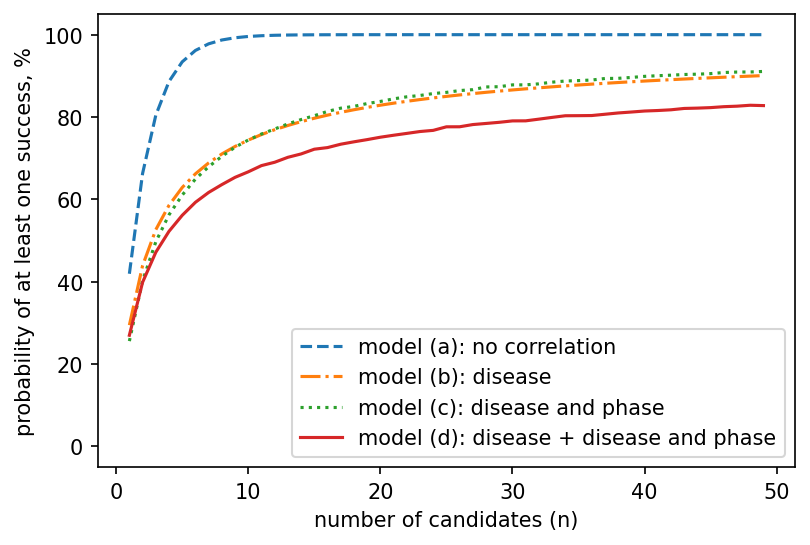

In [8]:
n = np.arange(1, 50)
if False:
    prob_a = np.zeros(len(n)); prob_b = np.zeros(len(n)); prob_c = np.zeros(len(n)); prob_d = np.zeros(len(n))
    for i in range(0, len(n)):
        prob_a[i] = vac_prob(pfa, nf = 0, n = n[i])
        prob_b[i] = vac_prob(pfb, nf = 1, n = n[i])
        prob_c[i] = vac_prob(pfc, nf = 3, n = n[i], mc = True, N = 1000)
        prob_d[i] = vac_prob(pfd, nf = 4, n = n[i], mc = True, N = 1000)
        print('{}: prob_a = {:.3f}, prob_a = {:.3f}, prob_c = {:.3f}, prob_d = {:.3f}'.format(n[i], prob_a[i], prob_b[i], prob_c[i], prob_d[i]))
    clear_output()
else:
    prob_a = np.array([0.41942, 0.66293, 0.8043, 0.88638, 0.93404, 0.9617, 0.97777, 0.98709, 0.99251, 0.99565, 0.99747, 0.99853, 0.99915, 0.99951, 0.99971, 0.99983, 0.9999, 0.99994, 0.99997, 0.99998, 0.99999, 0.99999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
    prob_b = np.array([0.2946, 0.43914, 0.52639, 0.5856, 0.62886, 0.66211, 0.68861, 0.71034, 0.72853, 0.74404, 0.75745, 0.76918, 0.77955, 0.7888, 0.7971, 0.80462, 0.81145, 0.8177, 0.82344, 0.82874, 0.83364, 0.8382, 0.84245, 0.84642, 0.85015, 0.85365, 0.85695, 0.86006, 0.863, 0.86579, 0.86844, 0.87095, 0.87335, 0.87564, 0.87782, 0.8799, 0.8819, 0.88381, 0.88565, 0.88741, 0.88911, 0.89074, 0.89231, 0.89382, 0.89528, 0.89669, 0.89805, 0.89936, 0.90064])
    prob_c = np.array([0.2559, 0.40226, 0.49693, 0.56259, 0.61048, 0.64933, 0.67931, 0.7045, 0.72672, 0.74415, 0.75877, 0.77095, 0.78331, 0.79388, 0.80323, 0.81364, 0.82152, 0.8259, 0.83276, 0.83789, 0.84413, 0.84912, 0.85239, 0.857, 0.85989, 0.86431, 0.8665, 0.87307, 0.87368, 0.87811, 0.87815, 0.8806, 0.88471, 0.88744, 0.88851, 0.88985, 0.89357, 0.89399, 0.89616, 0.8988, 0.90037, 0.90163, 0.90331, 0.90407, 0.90546, 0.90812, 0.90925, 0.90946, 0.91071])
    prob_d = np.array([0.27006, 0.39871, 0.47157, 0.5225, 0.56134, 0.59297, 0.61687, 0.63593, 0.65355, 0.66697, 0.68208, 0.69021, 0.70223, 0.7104, 0.72189, 0.72582, 0.73402, 0.73982, 0.74518, 0.75101, 0.75579, 0.76027, 0.76483, 0.76764, 0.77626, 0.77636, 0.78174, 0.78443, 0.7872, 0.79062, 0.79077, 0.79489, 0.79913, 0.80314, 0.80333, 0.80365, 0.80675, 0.80989, 0.81218, 0.81461, 0.81584, 0.81759, 0.82086, 0.82166, 0.82288, 0.82514, 0.82638, 0.82862, 0.82778])
    
plt.figure(dpi = 150)
plt.plot(n, 100*prob_a, '--', 
         n, 100*prob_b, '-.',
         n, 100*prob_c, ':', 
         n, 100*prob_d, '-'); 
plt.ylim((-5, 105))
plt.xlabel('number of candidates (n)')
plt.ylabel('probability of at least one success, %')
plt.legend(['model (a): no correlation', 'model (b): disease', 
            'model (c): disease and phase', 'model (d): disease + disease and phase']);

Example. Conditional probabilities of success

In [9]:
n = np.array([5,2,0])
nfailed = np.array([3, 0, 0])
phase = [0, 0, 0, 0, 0, 1, 1, 0.5, 0.5, 0.5]

if False:
    pc_a = vac_prob(pfa, nf = 0, n = n, nfailed = nfailed)
    pc_b = vac_prob(pfb, nf = 1, n = n, nfailed = nfailed)
    pc_c = vac_prob(pfc, nf = 3, n = n, nfailed = nfailed, mc = True, N = 1000000)
    pc_d = vac_prob(pfd, nf = 4, n = n, nfailed = nfailed, mc = True, N = 1000000)
else:
    pc_a = 0.98447918
    pc_b = 0.39803645
    pc_c = 0.67321150
    pc_d = 0.33833446    
    
pc = pd.DataFrame(
    [['model (a)' , 100*pc_a],
     ['model (b)' , 100*pc_b],
     ['model (c)' , 100*pc_c],
     ['model (d)' , 100*pc_d]], columns = ['model', 'probability of success']
)
pc

,model,probability of success
0,model (a),98.447918
1,model (b),39.803645
2,model (c),67.321150
3,model (d),33.833446


### 5.2 Transition Probabilities

In [10]:
pt = dict()
for v in ['s', 'a', 'b', 'c', 'd']: pt[v] = np.zeros(3)

pt['a'] = norm.cdf(-resa.p['mu']) 
pt['c'] = norm.cdf(-resc.p['mu'])

s = np.sum(outcomes, axis = 0)
print('s: ', end = '')
for j in range(0,3): 
    pt['s'][j] = s[j,1]/s[j,0]
    print('phase{} = {}/{} = {:.2f}%'.format(j+1, s[j,1], s[j,0], 100*pt['s'][j]), end = '')
    if j<2: print(', ', end = '')
print('')

for r in [resb, resd]:
    for j in range(0, 3):
        def pf(F):
            sigma = np.sqrt(1-r.p['beta']**2)
            return norm.cdf((-r.p['mu'][0:(j+1)]+r.p['beta'][0:(j+1)]*F)/sigma[0:(j+1)])
        pr = vac_prob(pf, nf = 1, n = 1, nph = j+1)
        if r == resb:
            pt['b'][j] = pr
        else:
            pt['d'][j] = pr

for j in reversed(range(1, 3)):
    pt['b'][j] = pt['b'][j]/pt['b'][j-1]
    pt['d'][j] = pt['d'][j]/pt['d'][j-1]

for v in ['a', 'b', 'c', 'd']:
    print('{}: phase1 = {:.2f}%, phase2 = {:.2f}%, phase3 = {:.2f}%'.format(v, 100*pt[v][0], 100*pt[v][1], 100*pt[v][2]))

s: phase1 = 1212/1488 = 81.45%, phase2 = 706/1071 = 65.92%, phase3 = 489/626 = 78.12%
a: phase1 = 81.45%, phase2 = 65.92%, phase3 = 78.12%
b: phase1 = 74.73%, phase2 = 57.39%, phase3 = 68.69%
c: phase1 = 75.12%, phase2 = 58.69%, phase3 = 58.11%
d: phase1 = 75.30%, phase2 = 57.87%, phase3 = 61.25%


### 5.3 Optimal Investment Strategy


average I for model a = 145.4154
average I for model b = 125.7154
average I for model c = 127.7380
average I for model d = 127.0286


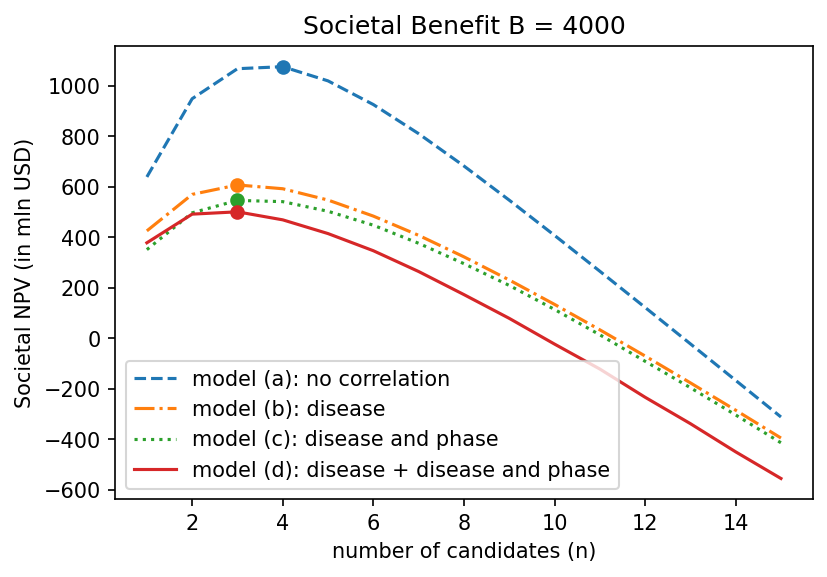

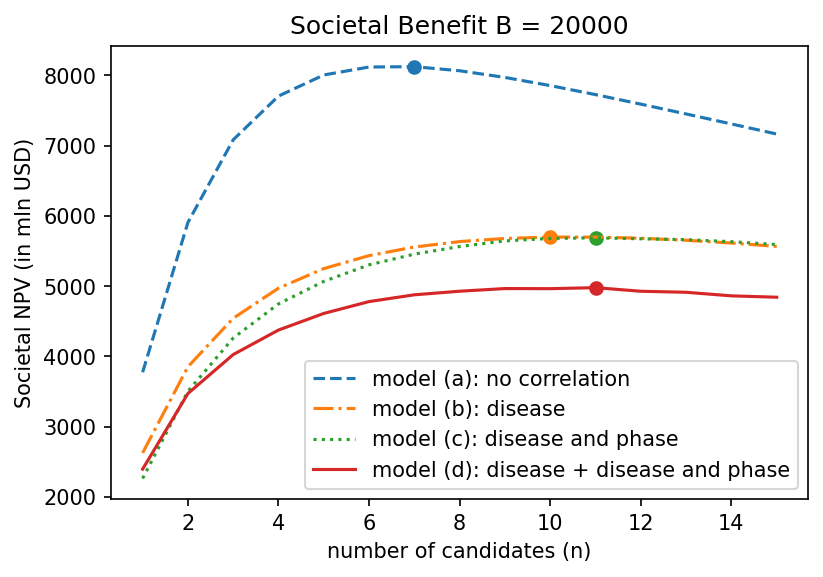

In [11]:
I = [25.3, 58.6, 255.4] # average cost of clinical trials per candidate in each phase(in mln USD)
B = [4000, 20000] # societal benefits from obtaining a successful drug/vaccine (in mln USD)
r = 0.1 # discount rate
T = [2.48, 2.86, 2.64]  # the average length of each phase

prob = {'a': prob_a, 'b': prob_b, 'c': prob_c, 'd': prob_d}
n = np.arange(1, 50)
idx = np.arange(0, 15)

Iave = dict()
for v in ['a', 'b', 'c', 'd']:
    Iave[v] = I[0] + pt[v][0]*I[1]/((1+r)**T[0]) + pt[v][0]*pt[v][1]*I[2]/((1+r)**(T[0]+T[1])) 
    print('average I for model {} = {:.4f}'.format(v, Iave[v]))
          
for j in range(0, len(B)):
    NPV = dict()
    for v in ['a', 'b', 'c', 'd']:
        NPV[v] = B[j]*prob[v]/((1+r)**sum(T)) - Iave[v]*n
    plt.figure(dpi = 150)
    plt.plot(n[idx], NPV['a'][idx], '--', 
             n[idx], NPV['b'][idx], '-.',
             n[idx], NPV['c'][idx], ':', 
             n[idx], NPV['d'][idx], '-'); 
    for v in ['a', 'b', 'c', 'd']:
        ns = n[idx]; NPVs = NPV[v][idx]
        plt.scatter(ns[np.argmax(NPVs)], NPVs[np.argmax(NPVs)])
    plt.xlabel('number of candidates (n)')
    plt.ylabel('Societal NPV (in mln USD)')
    plt.legend(['model (a): no correlation', 'model (b): disease', 
            'model (c): disease and phase', 'model (d): disease + disease and phase'])    
    plt.title('Societal Benefit B = {}'.format(B[j]));